In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaTokenizer, DebertaModel, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import AdamW
import accelerate

In [56]:
from tqdm import tqdm

In [57]:
df=pd.read_csv("dataset.csv")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [59]:
print(df.duplicated().sum())

141


In [60]:
df = df.drop_duplicates(subset='Text').reset_index(drop=True)

In [61]:
df.shape

(21859, 2)

In [62]:
df.isnull().sum().any()

False

In [63]:
df["language"].value_counts()

language
Chinese       1000
Thai          1000
English       1000
Japanese      1000
Turkish       1000
Romanian      1000
Urdu          1000
Persian       1000
Korean        1000
Estonian       999
Russian        999
Arabic         998
Portugese      997
Spanish        996
Dutch          996
Pushto         993
Swedish        992
Hindi          990
French         990
Tamil          981
Indonesian     975
Latin          953
Name: count, dtype: int64

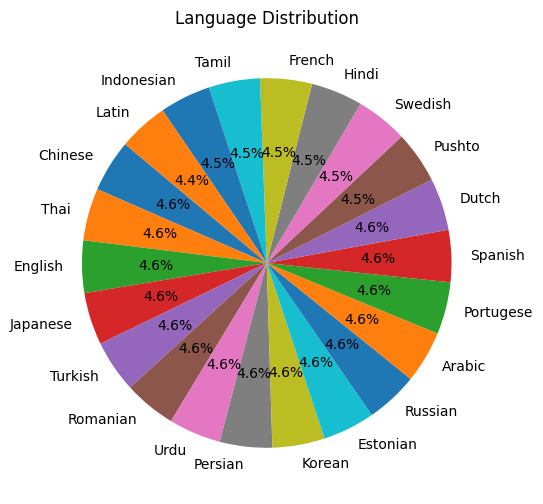

In [64]:
plt.figure(figsize=(8, 6))
df["language"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

/var/folders/n_/4p37f261177fmjpv4kt7x33m0000gn/T/ipykernel_49599/1061503432.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="language",data=df,palette="tab10")


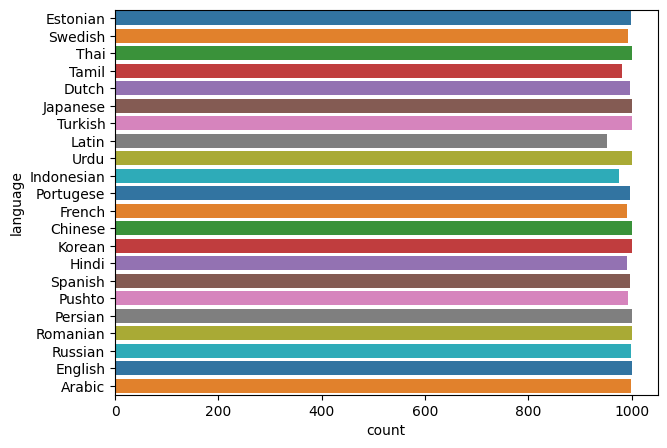

In [65]:
plt.figure(figsize=(7,5))
sns.countplot(y="language",data=df,palette="tab10")
plt.show()

In [66]:
df

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21854,hors du terrain les années et sont des année...,French
21855,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21856,con motivo de la celebración del septuagésimoq...,Spanish
21857,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


In [67]:
class LanguageIdentificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [68]:
class CustomDebertaModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomDebertaModel, self).__init__()
        self.deberta = DebertaModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.deberta.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.deberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sequence_output = outputs[0]
        pooled_output = sequence_output[:, 0, :]  # Take the [CLS] token's hidden state
        x = self.drop(pooled_output)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.drop(x)
        logits = self.fc2(x)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits

        return logits

In [69]:
len(df['language'].value_counts())

22

In [70]:
def prepare_data(df, tokenizer, max_len, batch_size):
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['language'])

    train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'], df['label'], test_size=0.2, random_state=42)

    train_dataset = LanguageIdentificationDataset(
        texts=train_texts.to_numpy(),
        labels=train_labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    val_dataset = LanguageIdentificationDataset(
        texts=val_texts.to_numpy(),
        labels=val_labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, le

In [71]:
def train_model(train_dataloader, val_dataloader, num_labels, model_name='microsoft/deberta-base', epochs=3):
    model = CustomDebertaModel(model_name, num_labels)
    optimizer = AdamW(model.parameters(), lr=1e-4)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy='epoch', 
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir='./logs',  # added logging_dir
        logging_steps=10,  # log every 10 steps
    )

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        accuracy = (preds == labels).mean()
        return {'accuracy': accuracy}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataloader.dataset,
        eval_dataset=val_dataloader.dataset,
        optimizers=(optimizer, None),  # AdamW optimizer with default scheduler
        compute_metrics=compute_metrics
    )

    trainer.train()

    return model

In [72]:
def main():
    # Load dataset
    df = pd.read_csv('dataset.csv')

    # Initialize tokenizer
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

    # Prepare data
    max_len = 128
    batch_size = 32
    train_dataloader, val_dataloader, le = prepare_data(df, tokenizer, max_len, batch_size)

    # Train model
    num_labels = len(le.classes_)
    model = train_model(train_dataloader, val_dataloader, num_labels)


    # Save the model state dictionary
    torch.save(model.state_dict(), './custom_deberta_language_model.pth')

    # Save the tokenizer
    tokenizer.save_pretrained('./custom_deberta_language_tokenizer')

    np.save('label_encoder_classes.npy', le.classes_)


In [73]:
main()

  0%|          | 10/3300 [00:03<20:13,  2.71it/s]

{'loss': 3.0283, 'grad_norm': 5.7590413093566895, 'learning_rate': 9.96969696969697e-05, 'epoch': 0.01}


  1%|          | 20/3300 [00:07<20:15,  2.70it/s]

{'loss': 2.847, 'grad_norm': 6.028165340423584, 'learning_rate': 9.939393939393939e-05, 'epoch': 0.02}


  1%|          | 30/3300 [00:11<20:11,  2.70it/s]

{'loss': 2.5777, 'grad_norm': 4.919329643249512, 'learning_rate': 9.909090909090911e-05, 'epoch': 0.03}


  1%|          | 40/3300 [00:14<19:50,  2.74it/s]

{'loss': 2.2234, 'grad_norm': 6.4125142097473145, 'learning_rate': 9.87878787878788e-05, 'epoch': 0.04}


  2%|▏         | 50/3300 [00:18<19:52,  2.73it/s]

{'loss': 1.919, 'grad_norm': 5.358924388885498, 'learning_rate': 9.848484848484849e-05, 'epoch': 0.05}


  2%|▏         | 60/3300 [00:22<19:44,  2.73it/s]

{'loss': 1.5885, 'grad_norm': 6.340829372406006, 'learning_rate': 9.818181818181818e-05, 'epoch': 0.05}


  2%|▏         | 70/3300 [00:25<19:37,  2.74it/s]

{'loss': 1.6549, 'grad_norm': 10.659159660339355, 'learning_rate': 9.787878787878789e-05, 'epoch': 0.06}


  2%|▏         | 80/3300 [00:29<19:42,  2.72it/s]

{'loss': 1.1174, 'grad_norm': 8.8966646194458, 'learning_rate': 9.757575757575758e-05, 'epoch': 0.07}


  3%|▎         | 90/3300 [00:33<19:38,  2.72it/s]

{'loss': 0.849, 'grad_norm': 7.126030445098877, 'learning_rate': 9.727272727272728e-05, 'epoch': 0.08}


  3%|▎         | 100/3300 [00:36<19:32,  2.73it/s]

{'loss': 0.5973, 'grad_norm': 12.116182327270508, 'learning_rate': 9.696969696969698e-05, 'epoch': 0.09}


  3%|▎         | 110/3300 [00:40<19:33,  2.72it/s]

{'loss': 0.6746, 'grad_norm': 7.577323913574219, 'learning_rate': 9.666666666666667e-05, 'epoch': 0.1}


  4%|▎         | 120/3300 [00:44<19:32,  2.71it/s]

{'loss': 0.52, 'grad_norm': 3.927603006362915, 'learning_rate': 9.636363636363637e-05, 'epoch': 0.11}


  4%|▍         | 130/3300 [00:47<19:29,  2.71it/s]

{'loss': 0.4, 'grad_norm': 6.517024993896484, 'learning_rate': 9.606060606060606e-05, 'epoch': 0.12}


  4%|▍         | 140/3300 [00:51<19:24,  2.71it/s]

{'loss': 0.3081, 'grad_norm': 25.056283950805664, 'learning_rate': 9.575757575757576e-05, 'epoch': 0.13}


  5%|▍         | 150/3300 [00:55<19:07,  2.74it/s]

{'loss': 0.3673, 'grad_norm': 1.8447495698928833, 'learning_rate': 9.545454545454546e-05, 'epoch': 0.14}


  5%|▍         | 160/3300 [00:58<19:19,  2.71it/s]

{'loss': 0.3226, 'grad_norm': 12.694777488708496, 'learning_rate': 9.515151515151515e-05, 'epoch': 0.15}


  5%|▌         | 170/3300 [01:02<19:14,  2.71it/s]

{'loss': 0.3693, 'grad_norm': 2.0007894039154053, 'learning_rate': 9.484848484848486e-05, 'epoch': 0.15}


  5%|▌         | 180/3300 [01:06<19:28,  2.67it/s]

{'loss': 0.3197, 'grad_norm': 1.9632679224014282, 'learning_rate': 9.454545454545455e-05, 'epoch': 0.16}


  6%|▌         | 190/3300 [01:10<19:26,  2.67it/s]

{'loss': 0.2675, 'grad_norm': 1.250161051750183, 'learning_rate': 9.424242424242424e-05, 'epoch': 0.17}


  6%|▌         | 200/3300 [01:13<19:22,  2.67it/s]

{'loss': 0.2379, 'grad_norm': 4.142014026641846, 'learning_rate': 9.393939393939395e-05, 'epoch': 0.18}


  6%|▋         | 210/3300 [01:17<19:18,  2.67it/s]

{'loss': 0.2686, 'grad_norm': 3.5139944553375244, 'learning_rate': 9.363636363636364e-05, 'epoch': 0.19}


  7%|▋         | 220/3300 [01:21<19:11,  2.67it/s]

{'loss': 0.2952, 'grad_norm': 0.7011731266975403, 'learning_rate': 9.333333333333334e-05, 'epoch': 0.2}


  7%|▋         | 230/3300 [01:25<19:12,  2.66it/s]

{'loss': 0.2652, 'grad_norm': 3.566981077194214, 'learning_rate': 9.303030303030303e-05, 'epoch': 0.21}


  7%|▋         | 240/3300 [01:28<19:16,  2.65it/s]

{'loss': 0.335, 'grad_norm': 2.3807711601257324, 'learning_rate': 9.272727272727273e-05, 'epoch': 0.22}


  8%|▊         | 250/3300 [01:32<19:05,  2.66it/s]

{'loss': 0.4124, 'grad_norm': 4.286865234375, 'learning_rate': 9.242424242424242e-05, 'epoch': 0.23}


  8%|▊         | 260/3300 [01:36<18:51,  2.69it/s]

{'loss': 0.2323, 'grad_norm': 7.962981224060059, 'learning_rate': 9.212121212121214e-05, 'epoch': 0.24}


  8%|▊         | 270/3300 [01:40<18:53,  2.67it/s]

{'loss': 0.3266, 'grad_norm': 0.6599899530410767, 'learning_rate': 9.181818181818183e-05, 'epoch': 0.25}


  8%|▊         | 280/3300 [01:43<18:48,  2.68it/s]

{'loss': 0.3199, 'grad_norm': 2.981173515319824, 'learning_rate': 9.151515151515152e-05, 'epoch': 0.25}


  9%|▉         | 290/3300 [01:47<18:41,  2.68it/s]

{'loss': 0.1718, 'grad_norm': 1.0670908689498901, 'learning_rate': 9.121212121212121e-05, 'epoch': 0.26}


  9%|▉         | 300/3300 [01:51<18:44,  2.67it/s]

{'loss': 0.2503, 'grad_norm': 1.2214473485946655, 'learning_rate': 9.090909090909092e-05, 'epoch': 0.27}


  9%|▉         | 310/3300 [01:55<18:30,  2.69it/s]

{'loss': 0.2089, 'grad_norm': 12.677111625671387, 'learning_rate': 9.060606060606061e-05, 'epoch': 0.28}


 10%|▉         | 320/3300 [01:58<18:31,  2.68it/s]

{'loss': 0.2056, 'grad_norm': 0.33210039138793945, 'learning_rate': 9.030303030303031e-05, 'epoch': 0.29}


 10%|█         | 330/3300 [02:02<18:22,  2.69it/s]

{'loss': 0.1324, 'grad_norm': 0.14891137182712555, 'learning_rate': 9e-05, 'epoch': 0.3}


 10%|█         | 340/3300 [02:06<18:24,  2.68it/s]

{'loss': 0.2089, 'grad_norm': 0.3227505385875702, 'learning_rate': 8.96969696969697e-05, 'epoch': 0.31}


 11%|█         | 350/3300 [02:09<18:27,  2.66it/s]

{'loss': 0.1674, 'grad_norm': 0.3159734308719635, 'learning_rate': 8.93939393939394e-05, 'epoch': 0.32}


 11%|█         | 360/3300 [02:13<18:10,  2.70it/s]

{'loss': 0.1948, 'grad_norm': 0.10879267007112503, 'learning_rate': 8.90909090909091e-05, 'epoch': 0.33}


 11%|█         | 370/3300 [02:17<18:12,  2.68it/s]

{'loss': 0.1039, 'grad_norm': 3.0896666049957275, 'learning_rate': 8.87878787878788e-05, 'epoch': 0.34}


 12%|█▏        | 380/3300 [02:21<18:05,  2.69it/s]

{'loss': 0.0905, 'grad_norm': 0.10026738792657852, 'learning_rate': 8.848484848484849e-05, 'epoch': 0.35}


 12%|█▏        | 390/3300 [02:24<18:01,  2.69it/s]

{'loss': 0.136, 'grad_norm': 0.6409006714820862, 'learning_rate': 8.818181818181818e-05, 'epoch': 0.35}


 12%|█▏        | 400/3300 [02:28<17:58,  2.69it/s]

{'loss': 0.0878, 'grad_norm': 0.06905987858772278, 'learning_rate': 8.787878787878789e-05, 'epoch': 0.36}


 12%|█▏        | 410/3300 [02:32<17:56,  2.69it/s]

{'loss': 0.1653, 'grad_norm': 20.622875213623047, 'learning_rate': 8.757575757575758e-05, 'epoch': 0.37}


 13%|█▎        | 420/3300 [02:36<17:51,  2.69it/s]

{'loss': 0.2224, 'grad_norm': 11.482719421386719, 'learning_rate': 8.727272727272727e-05, 'epoch': 0.38}


 13%|█▎        | 430/3300 [02:39<17:40,  2.71it/s]

{'loss': 0.2428, 'grad_norm': 0.17140425741672516, 'learning_rate': 8.696969696969698e-05, 'epoch': 0.39}


 13%|█▎        | 440/3300 [02:43<17:38,  2.70it/s]

{'loss': 0.1588, 'grad_norm': 0.9758809804916382, 'learning_rate': 8.666666666666667e-05, 'epoch': 0.4}


 14%|█▎        | 450/3300 [02:47<17:40,  2.69it/s]

{'loss': 0.1074, 'grad_norm': 0.40944090485572815, 'learning_rate': 8.636363636363637e-05, 'epoch': 0.41}


 14%|█▍        | 460/3300 [02:50<17:36,  2.69it/s]

{'loss': 0.0616, 'grad_norm': 0.09430645406246185, 'learning_rate': 8.606060606060606e-05, 'epoch': 0.42}


 14%|█▍        | 470/3300 [02:54<17:40,  2.67it/s]

{'loss': 0.2525, 'grad_norm': 0.18705719709396362, 'learning_rate': 8.575757575757576e-05, 'epoch': 0.43}


 15%|█▍        | 480/3300 [02:58<17:31,  2.68it/s]

{'loss': 0.2153, 'grad_norm': 10.640748977661133, 'learning_rate': 8.545454545454545e-05, 'epoch': 0.44}


 15%|█▍        | 490/3300 [03:02<17:29,  2.68it/s]

{'loss': 0.221, 'grad_norm': 0.3072662651538849, 'learning_rate': 8.515151515151515e-05, 'epoch': 0.45}


 15%|█▌        | 500/3300 [03:05<17:26,  2.68it/s]

{'loss': 0.3477, 'grad_norm': 0.2727787494659424, 'learning_rate': 8.484848484848486e-05, 'epoch': 0.45}


 15%|█▌        | 510/3300 [03:11<18:44,  2.48it/s]

{'loss': 0.2108, 'grad_norm': 0.21181251108646393, 'learning_rate': 8.454545454545455e-05, 'epoch': 0.46}


 16%|█▌        | 520/3300 [03:15<17:47,  2.60it/s]

{'loss': 0.1062, 'grad_norm': 6.809597492218018, 'learning_rate': 8.424242424242424e-05, 'epoch': 0.47}


 16%|█▌        | 530/3300 [03:18<17:53,  2.58it/s]

{'loss': 0.0886, 'grad_norm': 0.09908134490251541, 'learning_rate': 8.393939393939393e-05, 'epoch': 0.48}


 16%|█▋        | 540/3300 [03:22<18:06,  2.54it/s]

{'loss': 0.181, 'grad_norm': 0.11371686309576035, 'learning_rate': 8.363636363636364e-05, 'epoch': 0.49}


 17%|█▋        | 550/3300 [03:26<18:28,  2.48it/s]

{'loss': 0.0345, 'grad_norm': 7.572606563568115, 'learning_rate': 8.333333333333334e-05, 'epoch': 0.5}


 17%|█▋        | 560/3300 [03:30<18:48,  2.43it/s]

{'loss': 0.2455, 'grad_norm': 22.06439971923828, 'learning_rate': 8.303030303030304e-05, 'epoch': 0.51}


 17%|█▋        | 570/3300 [03:35<18:56,  2.40it/s]

{'loss': 0.1746, 'grad_norm': 2.5436336994171143, 'learning_rate': 8.272727272727273e-05, 'epoch': 0.52}


 18%|█▊        | 580/3300 [03:39<19:03,  2.38it/s]

{'loss': 0.1188, 'grad_norm': 3.6431941986083984, 'learning_rate': 8.242424242424243e-05, 'epoch': 0.53}


 18%|█▊        | 590/3300 [03:43<19:10,  2.36it/s]

{'loss': 0.1471, 'grad_norm': 12.754849433898926, 'learning_rate': 8.212121212121212e-05, 'epoch': 0.54}


 18%|█▊        | 600/3300 [03:47<19:25,  2.32it/s]

{'loss': 0.1, 'grad_norm': 2.7463130950927734, 'learning_rate': 8.181818181818183e-05, 'epoch': 0.55}


 18%|█▊        | 610/3300 [03:52<19:53,  2.25it/s]

{'loss': 0.0357, 'grad_norm': 0.6246168613433838, 'learning_rate': 8.151515151515152e-05, 'epoch': 0.55}


 19%|█▉        | 620/3300 [03:56<20:09,  2.22it/s]

{'loss': 0.1825, 'grad_norm': 0.0568130761384964, 'learning_rate': 8.121212121212121e-05, 'epoch': 0.56}


 19%|█▉        | 630/3300 [04:01<21:02,  2.12it/s]

{'loss': 0.1084, 'grad_norm': 0.040632374584674835, 'learning_rate': 8.090909090909092e-05, 'epoch': 0.57}


 19%|█▉        | 640/3300 [04:06<23:31,  1.88it/s]

{'loss': 0.0954, 'grad_norm': 1.5023736953735352, 'learning_rate': 8.060606060606061e-05, 'epoch': 0.58}


 20%|█▉        | 650/3300 [04:11<21:57,  2.01it/s]

{'loss': 0.1232, 'grad_norm': 0.2181023508310318, 'learning_rate': 8.03030303030303e-05, 'epoch': 0.59}


 20%|██        | 660/3300 [04:16<22:26,  1.96it/s]

{'loss': 0.3165, 'grad_norm': 109.2387466430664, 'learning_rate': 8e-05, 'epoch': 0.6}


 20%|██        | 670/3300 [04:21<23:10,  1.89it/s]

{'loss': 0.3599, 'grad_norm': 34.35955810546875, 'learning_rate': 7.96969696969697e-05, 'epoch': 0.61}


 21%|██        | 680/3300 [04:27<23:59,  1.82it/s]

{'loss': 0.1658, 'grad_norm': 0.9255460500717163, 'learning_rate': 7.93939393939394e-05, 'epoch': 0.62}


 21%|██        | 690/3300 [04:32<24:45,  1.76it/s]

{'loss': 0.4771, 'grad_norm': 19.64276695251465, 'learning_rate': 7.90909090909091e-05, 'epoch': 0.63}


 21%|██        | 700/3300 [04:39<26:21,  1.64it/s]

{'loss': 0.18, 'grad_norm': 0.5009958744049072, 'learning_rate': 7.878787878787879e-05, 'epoch': 0.64}


 22%|██▏       | 710/3300 [04:45<27:19,  1.58it/s]

{'loss': 0.2266, 'grad_norm': 0.19492745399475098, 'learning_rate': 7.848484848484848e-05, 'epoch': 0.65}


 22%|██▏       | 720/3300 [04:51<28:00,  1.53it/s]

{'loss': 0.1033, 'grad_norm': 0.057600755244493484, 'learning_rate': 7.818181818181818e-05, 'epoch': 0.65}


 22%|██▏       | 730/3300 [04:58<29:34,  1.45it/s]

{'loss': 0.1959, 'grad_norm': 0.05284012481570244, 'learning_rate': 7.787878787878789e-05, 'epoch': 0.66}


 22%|██▏       | 740/3300 [05:06<31:48,  1.34it/s]

{'loss': 0.1376, 'grad_norm': 0.4062819480895996, 'learning_rate': 7.757575757575758e-05, 'epoch': 0.67}


 23%|██▎       | 750/3300 [05:13<33:34,  1.27it/s]

{'loss': 0.1229, 'grad_norm': 0.3029555678367615, 'learning_rate': 7.727272727272727e-05, 'epoch': 0.68}


 23%|██▎       | 760/3300 [05:22<36:34,  1.16it/s]

{'loss': 0.1438, 'grad_norm': 8.118597030639648, 'learning_rate': 7.696969696969696e-05, 'epoch': 0.69}


 23%|██▎       | 770/3300 [05:32<41:31,  1.02it/s]

{'loss': 0.1304, 'grad_norm': 0.15628965198993683, 'learning_rate': 7.666666666666667e-05, 'epoch': 0.7}


 24%|██▎       | 780/3300 [05:42<46:17,  1.10s/it]

{'loss': 0.1618, 'grad_norm': 1.9030399322509766, 'learning_rate': 7.636363636363637e-05, 'epoch': 0.71}


 24%|██▍       | 790/3300 [05:54<50:40,  1.21s/it]

{'loss': 0.1732, 'grad_norm': 4.028693199157715, 'learning_rate': 7.606060606060607e-05, 'epoch': 0.72}


 24%|██▍       | 800/3300 [06:07<53:10,  1.28s/it]

{'loss': 0.1658, 'grad_norm': 30.760801315307617, 'learning_rate': 7.575757575757576e-05, 'epoch': 0.73}


 25%|██▍       | 810/3300 [06:19<48:10,  1.16s/it]

{'loss': 0.1495, 'grad_norm': 0.06026563420891762, 'learning_rate': 7.545454545454545e-05, 'epoch': 0.74}


 25%|██▍       | 820/3300 [06:30<43:14,  1.05s/it]

{'loss': 0.0523, 'grad_norm': 4.9044575691223145, 'learning_rate': 7.515151515151515e-05, 'epoch': 0.75}


 25%|██▌       | 830/3300 [06:39<38:24,  1.07it/s]

{'loss': 0.16, 'grad_norm': 0.10431499779224396, 'learning_rate': 7.484848484848486e-05, 'epoch': 0.75}


 25%|██▌       | 840/3300 [06:48<34:01,  1.21it/s]

{'loss': 0.0783, 'grad_norm': 3.4103682041168213, 'learning_rate': 7.454545454545455e-05, 'epoch': 0.76}


 26%|██▌       | 850/3300 [06:55<29:58,  1.36it/s]

{'loss': 0.0835, 'grad_norm': 7.081007957458496, 'learning_rate': 7.424242424242424e-05, 'epoch': 0.77}


 26%|██▌       | 860/3300 [07:02<27:00,  1.51it/s]

{'loss': 0.1905, 'grad_norm': 0.04977217689156532, 'learning_rate': 7.393939393939395e-05, 'epoch': 0.78}


 26%|██▋       | 870/3300 [07:09<26:12,  1.55it/s]

{'loss': 0.24, 'grad_norm': 0.19991077482700348, 'learning_rate': 7.363636363636364e-05, 'epoch': 0.79}


 27%|██▋       | 880/3300 [07:15<25:36,  1.57it/s]

{'loss': 0.1351, 'grad_norm': 0.5068476796150208, 'learning_rate': 7.333333333333333e-05, 'epoch': 0.8}


 27%|██▋       | 890/3300 [07:21<24:48,  1.62it/s]

{'loss': 0.1321, 'grad_norm': 1.6530683040618896, 'learning_rate': 7.303030303030304e-05, 'epoch': 0.81}


 27%|██▋       | 900/3300 [07:27<24:34,  1.63it/s]

{'loss': 0.2864, 'grad_norm': 0.17583152651786804, 'learning_rate': 7.272727272727273e-05, 'epoch': 0.82}


 28%|██▊       | 910/3300 [07:33<23:55,  1.66it/s]

{'loss': 0.0708, 'grad_norm': 0.09518333524465561, 'learning_rate': 7.242424242424243e-05, 'epoch': 0.83}


 28%|██▊       | 920/3300 [07:39<23:22,  1.70it/s]

{'loss': 0.188, 'grad_norm': 2.876798152923584, 'learning_rate': 7.212121212121213e-05, 'epoch': 0.84}


 28%|██▊       | 930/3300 [07:45<22:40,  1.74it/s]

{'loss': 0.1169, 'grad_norm': 0.24868254363536835, 'learning_rate': 7.181818181818182e-05, 'epoch': 0.85}


 28%|██▊       | 940/3300 [07:51<22:05,  1.78it/s]

{'loss': 0.2077, 'grad_norm': 0.08541437238454819, 'learning_rate': 7.151515151515152e-05, 'epoch': 0.85}


 29%|██▉       | 950/3300 [07:56<21:45,  1.80it/s]

{'loss': 0.1, 'grad_norm': 4.904661655426025, 'learning_rate': 7.121212121212121e-05, 'epoch': 0.86}


 29%|██▉       | 960/3300 [08:02<21:14,  1.84it/s]

{'loss': 0.097, 'grad_norm': 0.1872619390487671, 'learning_rate': 7.090909090909092e-05, 'epoch': 0.87}


 29%|██▉       | 970/3300 [08:07<20:54,  1.86it/s]

{'loss': 0.1323, 'grad_norm': 9.256911277770996, 'learning_rate': 7.060606060606061e-05, 'epoch': 0.88}


 30%|██▉       | 980/3300 [08:13<20:28,  1.89it/s]

{'loss': 0.1774, 'grad_norm': 2.7197484970092773, 'learning_rate': 7.03030303030303e-05, 'epoch': 0.89}


 30%|███       | 990/3300 [08:18<20:14,  1.90it/s]

{'loss': 0.2226, 'grad_norm': 0.45732107758522034, 'learning_rate': 7e-05, 'epoch': 0.9}


 30%|███       | 1000/3300 [08:23<20:40,  1.85it/s]

{'loss': 0.1588, 'grad_norm': 0.21983200311660767, 'learning_rate': 6.96969696969697e-05, 'epoch': 0.91}


 31%|███       | 1010/3300 [08:30<20:20,  1.88it/s]

{'loss': 0.142, 'grad_norm': 0.2593876123428345, 'learning_rate': 6.93939393939394e-05, 'epoch': 0.92}


 31%|███       | 1020/3300 [08:35<19:23,  1.96it/s]

{'loss': 0.1193, 'grad_norm': 0.054356589913368225, 'learning_rate': 6.90909090909091e-05, 'epoch': 0.93}


 31%|███       | 1030/3300 [08:40<19:03,  1.98it/s]

{'loss': 0.2314, 'grad_norm': 0.5326700806617737, 'learning_rate': 6.878787878787879e-05, 'epoch': 0.94}


 32%|███▏      | 1040/3300 [08:45<18:52,  2.00it/s]

{'loss': 0.1724, 'grad_norm': 11.46816349029541, 'learning_rate': 6.848484848484848e-05, 'epoch': 0.95}


 32%|███▏      | 1050/3300 [08:50<18:30,  2.03it/s]

{'loss': 0.1411, 'grad_norm': 0.1454540193080902, 'learning_rate': 6.818181818181818e-05, 'epoch': 0.95}


 32%|███▏      | 1060/3300 [08:55<18:12,  2.05it/s]

{'loss': 0.0972, 'grad_norm': 0.17636096477508545, 'learning_rate': 6.787878787878789e-05, 'epoch': 0.96}


 32%|███▏      | 1070/3300 [09:00<17:56,  2.07it/s]

{'loss': 0.1322, 'grad_norm': 0.03225194662809372, 'learning_rate': 6.757575757575758e-05, 'epoch': 0.97}


 33%|███▎      | 1080/3300 [09:04<17:58,  2.06it/s]

{'loss': 0.0751, 'grad_norm': 0.031863026320934296, 'learning_rate': 6.727272727272727e-05, 'epoch': 0.98}


 33%|███▎      | 1090/3300 [09:09<17:35,  2.09it/s]

{'loss': 0.22, 'grad_norm': 0.022897692397236824, 'learning_rate': 6.696969696969696e-05, 'epoch': 0.99}


 33%|███▎      | 1100/3300 [09:14<17:15,  2.13it/s]

{'loss': 0.112, 'grad_norm': 5.880349636077881, 'learning_rate': 6.666666666666667e-05, 'epoch': 1.0}


                                                   
 33%|███▎      | 1100/3300 [09:55<17:15,  2.13it/s]

{'eval_loss': 0.15653292834758759, 'eval_accuracy': 0.9775, 'eval_runtime': 40.7149, 'eval_samples_per_second': 108.069, 'eval_steps_per_second': 6.754, 'epoch': 1.0}


 34%|███▎      | 1110/3300 [09:59<34:14,  1.07it/s]  

{'loss': 0.1928, 'grad_norm': 0.219090536236763, 'learning_rate': 6.636363636363638e-05, 'epoch': 1.01}


 34%|███▍      | 1120/3300 [10:04<16:29,  2.20it/s]

{'loss': 0.1997, 'grad_norm': 0.03817577287554741, 'learning_rate': 6.606060606060607e-05, 'epoch': 1.02}


 34%|███▍      | 1130/3300 [10:08<16:00,  2.26it/s]

{'loss': 0.1344, 'grad_norm': 1.833524227142334, 'learning_rate': 6.575757575757576e-05, 'epoch': 1.03}


 35%|███▍      | 1140/3300 [10:12<15:50,  2.27it/s]

{'loss': 0.2593, 'grad_norm': 5.317034721374512, 'learning_rate': 6.545454545454546e-05, 'epoch': 1.04}


 35%|███▍      | 1150/3300 [10:17<15:43,  2.28it/s]

{'loss': 0.1135, 'grad_norm': 14.627180099487305, 'learning_rate': 6.515151515151516e-05, 'epoch': 1.05}


 35%|███▌      | 1160/3300 [10:21<15:36,  2.28it/s]

{'loss': 0.3097, 'grad_norm': 0.33142969012260437, 'learning_rate': 6.484848484848485e-05, 'epoch': 1.05}


 35%|███▌      | 1170/3300 [10:26<15:24,  2.30it/s]

{'loss': 0.4922, 'grad_norm': 7.386889457702637, 'learning_rate': 6.454545454545455e-05, 'epoch': 1.06}


 36%|███▌      | 1180/3300 [10:30<15:19,  2.31it/s]

{'loss': 0.2536, 'grad_norm': 0.09965971857309341, 'learning_rate': 6.424242424242424e-05, 'epoch': 1.07}


 36%|███▌      | 1190/3300 [10:34<15:15,  2.31it/s]

{'loss': 0.1776, 'grad_norm': 0.4632999897003174, 'learning_rate': 6.393939393939395e-05, 'epoch': 1.08}


 36%|███▋      | 1200/3300 [10:39<15:09,  2.31it/s]

{'loss': 0.3019, 'grad_norm': 9.68039608001709, 'learning_rate': 6.363636363636364e-05, 'epoch': 1.09}


 37%|███▋      | 1210/3300 [10:43<15:03,  2.31it/s]

{'loss': 0.2266, 'grad_norm': 1.9785561561584473, 'learning_rate': 6.333333333333333e-05, 'epoch': 1.1}


 37%|███▋      | 1220/3300 [10:47<14:56,  2.32it/s]

{'loss': 0.1597, 'grad_norm': 0.05736459791660309, 'learning_rate': 6.303030303030302e-05, 'epoch': 1.11}


 37%|███▋      | 1230/3300 [10:52<14:55,  2.31it/s]

{'loss': 0.0361, 'grad_norm': 0.054894328117370605, 'learning_rate': 6.272727272727273e-05, 'epoch': 1.12}


 38%|███▊      | 1240/3300 [10:56<14:40,  2.34it/s]

{'loss': 0.1486, 'grad_norm': 0.1766924113035202, 'learning_rate': 6.242424242424243e-05, 'epoch': 1.13}


 38%|███▊      | 1250/3300 [11:00<14:40,  2.33it/s]

{'loss': 0.1261, 'grad_norm': 0.07920484244823456, 'learning_rate': 6.212121212121213e-05, 'epoch': 1.14}


 38%|███▊      | 1260/3300 [11:05<14:33,  2.34it/s]

{'loss': 0.2228, 'grad_norm': 0.08977033197879791, 'learning_rate': 6.181818181818182e-05, 'epoch': 1.15}


 38%|███▊      | 1270/3300 [11:09<14:26,  2.34it/s]

{'loss': 0.131, 'grad_norm': 0.021551750600337982, 'learning_rate': 6.151515151515151e-05, 'epoch': 1.15}


 39%|███▉      | 1280/3300 [11:13<14:21,  2.34it/s]

{'loss': 0.0042, 'grad_norm': 14.79892349243164, 'learning_rate': 6.121212121212121e-05, 'epoch': 1.16}


 39%|███▉      | 1290/3300 [11:17<14:31,  2.31it/s]

{'loss': 0.0902, 'grad_norm': 0.0959760993719101, 'learning_rate': 6.090909090909091e-05, 'epoch': 1.17}


 39%|███▉      | 1300/3300 [11:22<14:17,  2.33it/s]

{'loss': 0.0919, 'grad_norm': 0.06687754392623901, 'learning_rate': 6.060606060606061e-05, 'epoch': 1.18}


 40%|███▉      | 1310/3300 [11:26<14:13,  2.33it/s]

{'loss': 0.1982, 'grad_norm': 7.87263298034668, 'learning_rate': 6.03030303030303e-05, 'epoch': 1.19}


 40%|████      | 1320/3300 [11:30<14:08,  2.33it/s]

{'loss': 0.0474, 'grad_norm': 0.19657528400421143, 'learning_rate': 6e-05, 'epoch': 1.2}


 40%|████      | 1330/3300 [11:35<14:02,  2.34it/s]

{'loss': 0.0896, 'grad_norm': 0.3418223261833191, 'learning_rate': 5.969696969696969e-05, 'epoch': 1.21}


 41%|████      | 1340/3300 [11:39<13:59,  2.34it/s]

{'loss': 0.0507, 'grad_norm': 0.03238552063703537, 'learning_rate': 5.93939393939394e-05, 'epoch': 1.22}


 41%|████      | 1350/3300 [11:43<14:00,  2.32it/s]

{'loss': 0.2313, 'grad_norm': 0.12063153833150864, 'learning_rate': 5.90909090909091e-05, 'epoch': 1.23}


 41%|████      | 1360/3300 [11:48<13:51,  2.33it/s]

{'loss': 0.0041, 'grad_norm': 0.03895549103617668, 'learning_rate': 5.878787878787879e-05, 'epoch': 1.24}


 42%|████▏     | 1370/3300 [11:52<13:52,  2.32it/s]

{'loss': 0.1772, 'grad_norm': 0.029016820713877678, 'learning_rate': 5.848484848484849e-05, 'epoch': 1.25}


 42%|████▏     | 1380/3300 [11:56<13:47,  2.32it/s]

{'loss': 0.1497, 'grad_norm': 0.13651661574840546, 'learning_rate': 5.818181818181818e-05, 'epoch': 1.25}


 42%|████▏     | 1390/3300 [12:00<13:42,  2.32it/s]

{'loss': 0.0649, 'grad_norm': 10.058135986328125, 'learning_rate': 5.787878787878788e-05, 'epoch': 1.26}


 42%|████▏     | 1400/3300 [12:05<13:38,  2.32it/s]

{'loss': 0.1251, 'grad_norm': 1.5972145795822144, 'learning_rate': 5.757575757575758e-05, 'epoch': 1.27}


 43%|████▎     | 1410/3300 [12:09<13:37,  2.31it/s]

{'loss': 0.141, 'grad_norm': 0.07569153606891632, 'learning_rate': 5.727272727272728e-05, 'epoch': 1.28}


 43%|████▎     | 1420/3300 [12:13<13:35,  2.31it/s]

{'loss': 0.1995, 'grad_norm': 0.08378928899765015, 'learning_rate': 5.696969696969697e-05, 'epoch': 1.29}


 43%|████▎     | 1430/3300 [12:18<13:28,  2.31it/s]

{'loss': 0.1017, 'grad_norm': 0.042108066380023956, 'learning_rate': 5.666666666666667e-05, 'epoch': 1.3}


 44%|████▎     | 1440/3300 [12:22<13:27,  2.30it/s]

{'loss': 0.0815, 'grad_norm': 0.0866202861070633, 'learning_rate': 5.636363636363636e-05, 'epoch': 1.31}


 44%|████▍     | 1450/3300 [12:27<13:22,  2.31it/s]

{'loss': 0.0902, 'grad_norm': 0.16506148874759674, 'learning_rate': 5.606060606060606e-05, 'epoch': 1.32}


 44%|████▍     | 1460/3300 [12:31<13:21,  2.30it/s]

{'loss': 0.1866, 'grad_norm': 0.029676567763090134, 'learning_rate': 5.5757575757575766e-05, 'epoch': 1.33}


 45%|████▍     | 1470/3300 [12:35<13:18,  2.29it/s]

{'loss': 0.1189, 'grad_norm': 0.09226742386817932, 'learning_rate': 5.545454545454546e-05, 'epoch': 1.34}


 45%|████▍     | 1480/3300 [12:40<13:14,  2.29it/s]

{'loss': 0.0072, 'grad_norm': 0.060259632766246796, 'learning_rate': 5.5151515151515156e-05, 'epoch': 1.35}


 45%|████▌     | 1490/3300 [12:44<13:16,  2.27it/s]

{'loss': 0.2043, 'grad_norm': 11.316267013549805, 'learning_rate': 5.484848484848485e-05, 'epoch': 1.35}


 45%|████▌     | 1500/3300 [12:49<13:10,  2.28it/s]

{'loss': 0.0783, 'grad_norm': 0.015914374962449074, 'learning_rate': 5.4545454545454546e-05, 'epoch': 1.36}


 46%|████▌     | 1510/3300 [12:55<13:47,  2.16it/s]

{'loss': 0.0967, 'grad_norm': 4.959414005279541, 'learning_rate': 5.424242424242425e-05, 'epoch': 1.37}


 46%|████▌     | 1520/3300 [12:59<13:12,  2.25it/s]

{'loss': 0.102, 'grad_norm': 0.1032118871808052, 'learning_rate': 5.393939393939394e-05, 'epoch': 1.38}


 46%|████▋     | 1530/3300 [13:03<13:17,  2.22it/s]

{'loss': 0.055, 'grad_norm': 0.1627194583415985, 'learning_rate': 5.363636363636364e-05, 'epoch': 1.39}


 47%|████▋     | 1540/3300 [13:08<13:21,  2.20it/s]

{'loss': 0.1339, 'grad_norm': 0.05233084782958031, 'learning_rate': 5.333333333333333e-05, 'epoch': 1.4}


 47%|████▋     | 1550/3300 [13:13<13:18,  2.19it/s]

{'loss': 0.086, 'grad_norm': 0.024599319323897362, 'learning_rate': 5.303030303030303e-05, 'epoch': 1.41}


 47%|████▋     | 1560/3300 [13:17<13:20,  2.17it/s]

{'loss': 0.0585, 'grad_norm': 0.02356528863310814, 'learning_rate': 5.272727272727272e-05, 'epoch': 1.42}


 48%|████▊     | 1570/3300 [13:22<13:30,  2.14it/s]

{'loss': 0.1748, 'grad_norm': 3.975104808807373, 'learning_rate': 5.242424242424243e-05, 'epoch': 1.43}


 48%|████▊     | 1580/3300 [13:27<13:34,  2.11it/s]

{'loss': 0.0755, 'grad_norm': 0.021361492574214935, 'learning_rate': 5.212121212121213e-05, 'epoch': 1.44}


 48%|████▊     | 1590/3300 [13:31<13:30,  2.11it/s]

{'loss': 0.1545, 'grad_norm': 0.018716933205723763, 'learning_rate': 5.181818181818182e-05, 'epoch': 1.45}


 48%|████▊     | 1600/3300 [13:36<13:33,  2.09it/s]

{'loss': 0.2102, 'grad_norm': 0.03922564163804054, 'learning_rate': 5.151515151515152e-05, 'epoch': 1.45}


 49%|████▉     | 1610/3300 [13:41<13:38,  2.06it/s]

{'loss': 0.0526, 'grad_norm': 2.582850456237793, 'learning_rate': 5.121212121212121e-05, 'epoch': 1.46}


 49%|████▉     | 1620/3300 [13:46<13:32,  2.07it/s]

{'loss': 0.0547, 'grad_norm': 0.12464983761310577, 'learning_rate': 5.090909090909091e-05, 'epoch': 1.47}


 49%|████▉     | 1630/3300 [13:51<13:39,  2.04it/s]

{'loss': 0.0476, 'grad_norm': 0.23868560791015625, 'learning_rate': 5.060606060606061e-05, 'epoch': 1.48}


 50%|████▉     | 1640/3300 [13:56<13:35,  2.04it/s]

{'loss': 0.1317, 'grad_norm': 0.048295486718416214, 'learning_rate': 5.030303030303031e-05, 'epoch': 1.49}


 50%|█████     | 1650/3300 [14:01<13:30,  2.03it/s]

{'loss': 0.1614, 'grad_norm': 0.07587040215730667, 'learning_rate': 5e-05, 'epoch': 1.5}


 50%|█████     | 1660/3300 [14:06<13:36,  2.01it/s]

{'loss': 0.1568, 'grad_norm': 53.30010223388672, 'learning_rate': 4.9696969696969694e-05, 'epoch': 1.51}


 51%|█████     | 1670/3300 [14:11<14:08,  1.92it/s]

{'loss': 0.0996, 'grad_norm': 4.115448474884033, 'learning_rate': 4.93939393939394e-05, 'epoch': 1.52}


 51%|█████     | 1680/3300 [14:16<13:54,  1.94it/s]

{'loss': 0.0556, 'grad_norm': 0.1549641638994217, 'learning_rate': 4.909090909090909e-05, 'epoch': 1.53}


 51%|█████     | 1690/3300 [14:21<13:40,  1.96it/s]

{'loss': 0.1965, 'grad_norm': 0.12753437459468842, 'learning_rate': 4.878787878787879e-05, 'epoch': 1.54}


 52%|█████▏    | 1700/3300 [14:26<13:29,  1.98it/s]

{'loss': 0.0307, 'grad_norm': 0.0729692280292511, 'learning_rate': 4.848484848484849e-05, 'epoch': 1.55}


 52%|█████▏    | 1710/3300 [14:31<13:34,  1.95it/s]

{'loss': 0.1427, 'grad_norm': 0.2508491575717926, 'learning_rate': 4.8181818181818186e-05, 'epoch': 1.55}


 52%|█████▏    | 1720/3300 [14:36<13:30,  1.95it/s]

{'loss': 0.0209, 'grad_norm': 0.3584398329257965, 'learning_rate': 4.787878787878788e-05, 'epoch': 1.56}


 52%|█████▏    | 1730/3300 [14:42<13:25,  1.95it/s]

{'loss': 0.0281, 'grad_norm': 0.2092529535293579, 'learning_rate': 4.7575757575757576e-05, 'epoch': 1.57}


 53%|█████▎    | 1740/3300 [14:47<13:22,  1.94it/s]

{'loss': 0.0032, 'grad_norm': 0.08323760330677032, 'learning_rate': 4.7272727272727275e-05, 'epoch': 1.58}


 53%|█████▎    | 1750/3300 [14:52<13:22,  1.93it/s]

{'loss': 0.2008, 'grad_norm': 22.947633743286133, 'learning_rate': 4.696969696969697e-05, 'epoch': 1.59}


 53%|█████▎    | 1760/3300 [14:57<13:18,  1.93it/s]

{'loss': 0.0364, 'grad_norm': 0.026470523327589035, 'learning_rate': 4.666666666666667e-05, 'epoch': 1.6}


 54%|█████▎    | 1770/3300 [15:02<13:11,  1.93it/s]

{'loss': 0.0346, 'grad_norm': 0.02825232408940792, 'learning_rate': 4.636363636363636e-05, 'epoch': 1.61}


 54%|█████▍    | 1780/3300 [15:07<13:00,  1.95it/s]

{'loss': 0.1147, 'grad_norm': 0.07109985500574112, 'learning_rate': 4.606060606060607e-05, 'epoch': 1.62}


 54%|█████▍    | 1790/3300 [15:13<12:58,  1.94it/s]

{'loss': 0.0665, 'grad_norm': 0.02005588635802269, 'learning_rate': 4.575757575757576e-05, 'epoch': 1.63}


 55%|█████▍    | 1800/3300 [15:18<12:51,  1.94it/s]

{'loss': 0.0131, 'grad_norm': 0.013560768216848373, 'learning_rate': 4.545454545454546e-05, 'epoch': 1.64}


 55%|█████▍    | 1810/3300 [15:23<12:45,  1.95it/s]

{'loss': 0.1403, 'grad_norm': 0.057258669286966324, 'learning_rate': 4.515151515151516e-05, 'epoch': 1.65}


 55%|█████▌    | 1820/3300 [15:28<12:40,  1.95it/s]

{'loss': 0.0077, 'grad_norm': 0.0284358449280262, 'learning_rate': 4.484848484848485e-05, 'epoch': 1.65}


 55%|█████▌    | 1830/3300 [15:33<12:37,  1.94it/s]

{'loss': 0.1129, 'grad_norm': 0.06592386960983276, 'learning_rate': 4.454545454545455e-05, 'epoch': 1.66}


 56%|█████▌    | 1840/3300 [15:38<12:27,  1.95it/s]

{'loss': 0.0267, 'grad_norm': 0.02567015029489994, 'learning_rate': 4.4242424242424246e-05, 'epoch': 1.67}


 56%|█████▌    | 1850/3300 [15:44<12:19,  1.96it/s]

{'loss': 0.2093, 'grad_norm': 2.5175349712371826, 'learning_rate': 4.3939393939393944e-05, 'epoch': 1.68}


 56%|█████▋    | 1860/3300 [15:49<12:07,  1.98it/s]

{'loss': 0.1309, 'grad_norm': 0.1589473932981491, 'learning_rate': 4.3636363636363636e-05, 'epoch': 1.69}


 57%|█████▋    | 1870/3300 [15:54<12:02,  1.98it/s]

{'loss': 0.0961, 'grad_norm': 0.03287994861602783, 'learning_rate': 4.3333333333333334e-05, 'epoch': 1.7}


 57%|█████▋    | 1880/3300 [15:59<11:52,  1.99it/s]

{'loss': 0.0768, 'grad_norm': 0.1257959008216858, 'learning_rate': 4.303030303030303e-05, 'epoch': 1.71}


 57%|█████▋    | 1890/3300 [16:04<11:43,  2.00it/s]

{'loss': 0.0921, 'grad_norm': 0.14220690727233887, 'learning_rate': 4.2727272727272724e-05, 'epoch': 1.72}


 58%|█████▊    | 1900/3300 [16:09<11:32,  2.02it/s]

{'loss': 0.0734, 'grad_norm': 0.0819685086607933, 'learning_rate': 4.242424242424243e-05, 'epoch': 1.73}


 58%|█████▊    | 1910/3300 [16:14<11:28,  2.02it/s]

{'loss': 0.0649, 'grad_norm': 0.10801386088132858, 'learning_rate': 4.212121212121212e-05, 'epoch': 1.74}


 58%|█████▊    | 1920/3300 [16:19<11:34,  1.99it/s]

{'loss': 0.207, 'grad_norm': 3.1065828800201416, 'learning_rate': 4.181818181818182e-05, 'epoch': 1.75}


 58%|█████▊    | 1930/3300 [16:24<11:13,  2.03it/s]

{'loss': 0.0823, 'grad_norm': 2.423759937286377, 'learning_rate': 4.151515151515152e-05, 'epoch': 1.75}


 59%|█████▉    | 1940/3300 [16:28<11:11,  2.03it/s]

{'loss': 0.1241, 'grad_norm': 3.571786880493164, 'learning_rate': 4.1212121212121216e-05, 'epoch': 1.76}


 59%|█████▉    | 1950/3300 [16:33<11:04,  2.03it/s]

{'loss': 0.052, 'grad_norm': 0.17241144180297852, 'learning_rate': 4.0909090909090915e-05, 'epoch': 1.77}


 59%|█████▉    | 1960/3300 [16:38<10:51,  2.06it/s]

{'loss': 0.1063, 'grad_norm': 0.010162879712879658, 'learning_rate': 4.0606060606060606e-05, 'epoch': 1.78}


 60%|█████▉    | 1970/3300 [16:43<10:47,  2.05it/s]

{'loss': 0.1749, 'grad_norm': 0.11905539035797119, 'learning_rate': 4.0303030303030305e-05, 'epoch': 1.79}


 60%|██████    | 1980/3300 [16:48<10:36,  2.08it/s]

{'loss': 0.076, 'grad_norm': 3.678928852081299, 'learning_rate': 4e-05, 'epoch': 1.8}


 60%|██████    | 1990/3300 [16:53<10:30,  2.08it/s]

{'loss': 0.0326, 'grad_norm': 0.20971627533435822, 'learning_rate': 3.96969696969697e-05, 'epoch': 1.81}


 61%|██████    | 2000/3300 [16:58<10:23,  2.09it/s]

{'loss': 0.056, 'grad_norm': 0.11356091499328613, 'learning_rate': 3.939393939393939e-05, 'epoch': 1.82}


 61%|██████    | 2010/3300 [17:04<10:51,  1.98it/s]

{'loss': 0.2164, 'grad_norm': 0.41351017355918884, 'learning_rate': 3.909090909090909e-05, 'epoch': 1.83}


 61%|██████    | 2020/3300 [17:09<10:47,  1.98it/s]

{'loss': 0.0281, 'grad_norm': 0.21749697625637054, 'learning_rate': 3.878787878787879e-05, 'epoch': 1.84}


 62%|██████▏   | 2030/3300 [17:14<10:18,  2.05it/s]

{'loss': 0.1316, 'grad_norm': 2.8994622230529785, 'learning_rate': 3.848484848484848e-05, 'epoch': 1.85}


 62%|██████▏   | 2040/3300 [17:19<10:08,  2.07it/s]

{'loss': 0.092, 'grad_norm': 3.590122699737549, 'learning_rate': 3.818181818181819e-05, 'epoch': 1.85}


 62%|██████▏   | 2050/3300 [17:24<09:57,  2.09it/s]

{'loss': 0.1705, 'grad_norm': 0.025056954473257065, 'learning_rate': 3.787878787878788e-05, 'epoch': 1.86}


 62%|██████▏   | 2060/3300 [17:28<09:55,  2.08it/s]

{'loss': 0.0576, 'grad_norm': 0.02773928828537464, 'learning_rate': 3.757575757575758e-05, 'epoch': 1.87}


 63%|██████▎   | 2070/3300 [17:33<09:58,  2.06it/s]

{'loss': 0.0621, 'grad_norm': 0.20316679775714874, 'learning_rate': 3.7272727272727276e-05, 'epoch': 1.88}


 63%|██████▎   | 2080/3300 [17:38<09:56,  2.05it/s]

{'loss': 0.2037, 'grad_norm': 0.2346441149711609, 'learning_rate': 3.6969696969696974e-05, 'epoch': 1.89}


 63%|██████▎   | 2090/3300 [17:43<09:52,  2.04it/s]

{'loss': 0.1157, 'grad_norm': 0.1470310091972351, 'learning_rate': 3.6666666666666666e-05, 'epoch': 1.9}


 64%|██████▎   | 2100/3300 [17:48<09:59,  2.00it/s]

{'loss': 0.1325, 'grad_norm': 0.1412956416606903, 'learning_rate': 3.6363636363636364e-05, 'epoch': 1.91}


 64%|██████▍   | 2110/3300 [17:53<09:49,  2.02it/s]

{'loss': 0.0492, 'grad_norm': 0.05228095501661301, 'learning_rate': 3.606060606060606e-05, 'epoch': 1.92}


 64%|██████▍   | 2120/3300 [17:58<09:46,  2.01it/s]

{'loss': 0.1009, 'grad_norm': 0.07964453846216202, 'learning_rate': 3.575757575757576e-05, 'epoch': 1.93}


 65%|██████▍   | 2130/3300 [18:03<09:06,  2.14it/s]

{'loss': 0.133, 'grad_norm': 8.06791877746582, 'learning_rate': 3.545454545454546e-05, 'epoch': 1.94}


 65%|██████▍   | 2140/3300 [18:08<09:02,  2.14it/s]

{'loss': 0.0719, 'grad_norm': 0.1358317732810974, 'learning_rate': 3.515151515151515e-05, 'epoch': 1.95}


 65%|██████▌   | 2150/3300 [18:12<08:55,  2.15it/s]

{'loss': 0.0549, 'grad_norm': 0.025317734107375145, 'learning_rate': 3.484848484848485e-05, 'epoch': 1.95}


 65%|██████▌   | 2160/3300 [18:17<08:47,  2.16it/s]

{'loss': 0.1027, 'grad_norm': 0.14856894314289093, 'learning_rate': 3.454545454545455e-05, 'epoch': 1.96}


 66%|██████▌   | 2170/3300 [18:22<08:55,  2.11it/s]

{'loss': 0.0299, 'grad_norm': 2.9167935848236084, 'learning_rate': 3.424242424242424e-05, 'epoch': 1.97}


 66%|██████▌   | 2180/3300 [18:27<09:36,  1.94it/s]

{'loss': 0.0351, 'grad_norm': 0.15443001687526703, 'learning_rate': 3.3939393939393945e-05, 'epoch': 1.98}


 66%|██████▋   | 2190/3300 [18:31<08:38,  2.14it/s]

{'loss': 0.0511, 'grad_norm': 0.3017178177833557, 'learning_rate': 3.3636363636363636e-05, 'epoch': 1.99}


 67%|██████▋   | 2200/3300 [18:36<08:37,  2.12it/s]

{'loss': 0.2803, 'grad_norm': 0.571808934211731, 'learning_rate': 3.3333333333333335e-05, 'epoch': 2.0}


                                                   
 67%|██████▋   | 2200/3300 [19:19<08:37,  2.12it/s]

{'eval_loss': 0.12114246934652328, 'eval_accuracy': 0.9815909090909091, 'eval_runtime': 42.6953, 'eval_samples_per_second': 103.056, 'eval_steps_per_second': 6.441, 'epoch': 2.0}


 67%|██████▋   | 2210/3300 [19:24<17:45,  1.02it/s]  

{'loss': 0.0829, 'grad_norm': 2.785031318664551, 'learning_rate': 3.303030303030303e-05, 'epoch': 2.01}


 67%|██████▋   | 2220/3300 [19:28<08:59,  2.00it/s]

{'loss': 0.1039, 'grad_norm': 0.1918669193983078, 'learning_rate': 3.272727272727273e-05, 'epoch': 2.02}


 68%|██████▊   | 2230/3300 [19:33<08:33,  2.08it/s]

{'loss': 0.0836, 'grad_norm': 0.14676079154014587, 'learning_rate': 3.2424242424242423e-05, 'epoch': 2.03}


 68%|██████▊   | 2240/3300 [19:38<08:32,  2.07it/s]

{'loss': 0.1807, 'grad_norm': 3.010871171951294, 'learning_rate': 3.212121212121212e-05, 'epoch': 2.04}


 68%|██████▊   | 2250/3300 [19:43<08:33,  2.04it/s]

{'loss': 0.0831, 'grad_norm': 2.894739866256714, 'learning_rate': 3.181818181818182e-05, 'epoch': 2.05}


 68%|██████▊   | 2260/3300 [19:48<08:43,  1.99it/s]

{'loss': 0.0527, 'grad_norm': 2.9379594326019287, 'learning_rate': 3.151515151515151e-05, 'epoch': 2.05}


 69%|██████▉   | 2270/3300 [19:53<08:40,  1.98it/s]

{'loss': 0.0247, 'grad_norm': 0.03600475192070007, 'learning_rate': 3.121212121212122e-05, 'epoch': 2.06}


 69%|██████▉   | 2280/3300 [19:58<08:01,  2.12it/s]

{'loss': 0.1083, 'grad_norm': 0.04774845391511917, 'learning_rate': 3.090909090909091e-05, 'epoch': 2.07}


 69%|██████▉   | 2290/3300 [20:03<08:07,  2.07it/s]

{'loss': 0.1933, 'grad_norm': 0.03443746268749237, 'learning_rate': 3.060606060606061e-05, 'epoch': 2.08}


 70%|██████▉   | 2300/3300 [20:07<07:48,  2.14it/s]

{'loss': 0.0841, 'grad_norm': 0.08294786512851715, 'learning_rate': 3.0303030303030306e-05, 'epoch': 2.09}


 70%|███████   | 2310/3300 [20:12<07:41,  2.14it/s]

{'loss': 0.1276, 'grad_norm': 3.663318634033203, 'learning_rate': 3e-05, 'epoch': 2.1}


 70%|███████   | 2320/3300 [20:17<07:36,  2.15it/s]

{'loss': 0.0065, 'grad_norm': 0.1698388010263443, 'learning_rate': 2.96969696969697e-05, 'epoch': 2.11}


 71%|███████   | 2330/3300 [20:21<07:21,  2.20it/s]

{'loss': 0.0023, 'grad_norm': 0.031236974522471428, 'learning_rate': 2.9393939393939394e-05, 'epoch': 2.12}


 71%|███████   | 2340/3300 [20:26<07:51,  2.04it/s]

{'loss': 0.0578, 'grad_norm': 0.05154923349618912, 'learning_rate': 2.909090909090909e-05, 'epoch': 2.13}


 71%|███████   | 2350/3300 [20:31<07:37,  2.07it/s]

{'loss': 0.1392, 'grad_norm': 0.10757365077733994, 'learning_rate': 2.878787878787879e-05, 'epoch': 2.14}


 72%|███████▏  | 2360/3300 [20:36<07:30,  2.09it/s]

{'loss': 0.0424, 'grad_norm': 3.5373570919036865, 'learning_rate': 2.8484848484848486e-05, 'epoch': 2.15}


 72%|███████▏  | 2370/3300 [20:41<07:34,  2.05it/s]

{'loss': 0.1695, 'grad_norm': 0.15337055921554565, 'learning_rate': 2.818181818181818e-05, 'epoch': 2.15}


 72%|███████▏  | 2380/3300 [20:45<07:13,  2.12it/s]

{'loss': 0.0239, 'grad_norm': 0.020277392119169235, 'learning_rate': 2.7878787878787883e-05, 'epoch': 2.16}


 72%|███████▏  | 2390/3300 [20:50<07:17,  2.08it/s]

{'loss': 0.1257, 'grad_norm': 0.02783355675637722, 'learning_rate': 2.7575757575757578e-05, 'epoch': 2.17}


 73%|███████▎  | 2400/3300 [20:55<07:08,  2.10it/s]

{'loss': 0.0649, 'grad_norm': 0.020891593769192696, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.18}


 73%|███████▎  | 2410/3300 [21:00<07:13,  2.05it/s]

{'loss': 0.1501, 'grad_norm': 0.05011481046676636, 'learning_rate': 2.696969696969697e-05, 'epoch': 2.19}


 73%|███████▎  | 2420/3300 [21:05<07:06,  2.06it/s]

{'loss': 0.0772, 'grad_norm': 0.07983546704053879, 'learning_rate': 2.6666666666666667e-05, 'epoch': 2.2}


 74%|███████▎  | 2430/3300 [21:10<07:22,  1.97it/s]

{'loss': 0.0029, 'grad_norm': 0.018283873796463013, 'learning_rate': 2.636363636363636e-05, 'epoch': 2.21}


 74%|███████▍  | 2440/3300 [21:15<06:43,  2.13it/s]

{'loss': 0.089, 'grad_norm': 4.376626968383789, 'learning_rate': 2.6060606060606063e-05, 'epoch': 2.22}


 74%|███████▍  | 2450/3300 [21:20<06:40,  2.12it/s]

{'loss': 0.0023, 'grad_norm': 0.017669854685664177, 'learning_rate': 2.575757575757576e-05, 'epoch': 2.23}


 75%|███████▍  | 2460/3300 [21:25<06:54,  2.03it/s]

{'loss': 0.053, 'grad_norm': 6.483862400054932, 'learning_rate': 2.5454545454545454e-05, 'epoch': 2.24}


 75%|███████▍  | 2470/3300 [21:29<06:24,  2.16it/s]

{'loss': 0.0759, 'grad_norm': 8.3056001663208, 'learning_rate': 2.5151515151515155e-05, 'epoch': 2.25}


 75%|███████▌  | 2480/3300 [21:34<06:18,  2.17it/s]

{'loss': 0.066, 'grad_norm': 0.07409137487411499, 'learning_rate': 2.4848484848484847e-05, 'epoch': 2.25}


 75%|███████▌  | 2490/3300 [21:39<06:12,  2.17it/s]

{'loss': 0.1113, 'grad_norm': 0.0650179535150528, 'learning_rate': 2.4545454545454545e-05, 'epoch': 2.26}


 76%|███████▌  | 2500/3300 [21:43<06:11,  2.15it/s]

{'loss': 0.0339, 'grad_norm': 0.019602704793214798, 'learning_rate': 2.4242424242424244e-05, 'epoch': 2.27}


 76%|███████▌  | 2510/3300 [21:49<06:13,  2.11it/s]

{'loss': 0.0068, 'grad_norm': 0.02606123685836792, 'learning_rate': 2.393939393939394e-05, 'epoch': 2.28}


 76%|███████▋  | 2520/3300 [21:54<05:55,  2.19it/s]

{'loss': 0.0939, 'grad_norm': 0.024129008874297142, 'learning_rate': 2.3636363636363637e-05, 'epoch': 2.29}


 77%|███████▋  | 2530/3300 [21:59<05:54,  2.17it/s]

{'loss': 0.0294, 'grad_norm': 0.24027277529239655, 'learning_rate': 2.3333333333333336e-05, 'epoch': 2.3}


 77%|███████▋  | 2540/3300 [22:03<06:03,  2.09it/s]

{'loss': 0.138, 'grad_norm': 0.02211742475628853, 'learning_rate': 2.3030303030303034e-05, 'epoch': 2.31}


 77%|███████▋  | 2550/3300 [22:08<06:19,  1.98it/s]

{'loss': 0.042, 'grad_norm': 0.03920184075832367, 'learning_rate': 2.272727272727273e-05, 'epoch': 2.32}


 78%|███████▊  | 2560/3300 [22:14<06:24,  1.92it/s]

{'loss': 0.0667, 'grad_norm': 0.03287787735462189, 'learning_rate': 2.2424242424242424e-05, 'epoch': 2.33}


 78%|███████▊  | 2570/3300 [22:19<06:24,  1.90it/s]

{'loss': 0.0035, 'grad_norm': 0.03231412544846535, 'learning_rate': 2.2121212121212123e-05, 'epoch': 2.34}


 78%|███████▊  | 2580/3300 [22:23<05:40,  2.12it/s]

{'loss': 0.135, 'grad_norm': 15.962815284729004, 'learning_rate': 2.1818181818181818e-05, 'epoch': 2.35}


 78%|███████▊  | 2590/3300 [22:28<05:33,  2.13it/s]

{'loss': 0.1187, 'grad_norm': 0.015711825340986252, 'learning_rate': 2.1515151515151516e-05, 'epoch': 2.35}


 79%|███████▉  | 2600/3300 [22:33<05:45,  2.03it/s]

{'loss': 0.0348, 'grad_norm': 0.01779106818139553, 'learning_rate': 2.1212121212121215e-05, 'epoch': 2.36}


 79%|███████▉  | 2610/3300 [22:38<05:51,  1.97it/s]

{'loss': 0.0472, 'grad_norm': 0.011978800408542156, 'learning_rate': 2.090909090909091e-05, 'epoch': 2.37}


 79%|███████▉  | 2620/3300 [22:43<05:54,  1.92it/s]

{'loss': 0.0154, 'grad_norm': 0.016642581671476364, 'learning_rate': 2.0606060606060608e-05, 'epoch': 2.38}


 80%|███████▉  | 2630/3300 [22:48<05:36,  1.99it/s]

{'loss': 0.0705, 'grad_norm': 5.398321151733398, 'learning_rate': 2.0303030303030303e-05, 'epoch': 2.39}


 80%|████████  | 2640/3300 [22:53<05:29,  2.00it/s]

{'loss': 0.015, 'grad_norm': 0.031151283532381058, 'learning_rate': 2e-05, 'epoch': 2.4}


 80%|████████  | 2650/3300 [22:58<05:07,  2.11it/s]

{'loss': 0.1192, 'grad_norm': 2.77895188331604, 'learning_rate': 1.9696969696969697e-05, 'epoch': 2.41}


 81%|████████  | 2660/3300 [23:03<05:05,  2.09it/s]

{'loss': 0.1155, 'grad_norm': 5.231979846954346, 'learning_rate': 1.9393939393939395e-05, 'epoch': 2.42}


 81%|████████  | 2670/3300 [23:08<05:24,  1.94it/s]

{'loss': 0.0709, 'grad_norm': 5.775561332702637, 'learning_rate': 1.9090909090909094e-05, 'epoch': 2.43}


 81%|████████  | 2680/3300 [23:13<05:00,  2.06it/s]

{'loss': 0.1579, 'grad_norm': 0.03966435045003891, 'learning_rate': 1.878787878787879e-05, 'epoch': 2.44}


 82%|████████▏ | 2690/3300 [23:17<05:05,  1.99it/s]

{'loss': 0.0449, 'grad_norm': 0.07917871326208115, 'learning_rate': 1.8484848484848487e-05, 'epoch': 2.45}


 82%|████████▏ | 2700/3300 [23:23<05:11,  1.93it/s]

{'loss': 0.0255, 'grad_norm': 0.020694633945822716, 'learning_rate': 1.8181818181818182e-05, 'epoch': 2.45}


 82%|████████▏ | 2710/3300 [23:28<05:00,  1.96it/s]

{'loss': 0.0377, 'grad_norm': 0.01615019328892231, 'learning_rate': 1.787878787878788e-05, 'epoch': 2.46}


 82%|████████▏ | 2720/3300 [23:33<04:50,  2.00it/s]

{'loss': 0.0991, 'grad_norm': 26.82955551147461, 'learning_rate': 1.7575757575757576e-05, 'epoch': 2.47}


 83%|████████▎ | 2730/3300 [23:38<04:39,  2.04it/s]

{'loss': 0.1054, 'grad_norm': 0.19113227725028992, 'learning_rate': 1.7272727272727274e-05, 'epoch': 2.48}


 83%|████████▎ | 2740/3300 [23:43<04:34,  2.04it/s]

{'loss': 0.0437, 'grad_norm': 0.019547972828149796, 'learning_rate': 1.6969696969696972e-05, 'epoch': 2.49}


 83%|████████▎ | 2750/3300 [23:48<04:24,  2.08it/s]

{'loss': 0.1139, 'grad_norm': 1.1290502548217773, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.5}


 84%|████████▎ | 2760/3300 [23:52<04:18,  2.09it/s]

{'loss': 0.0231, 'grad_norm': 0.030999962240457535, 'learning_rate': 1.6363636363636366e-05, 'epoch': 2.51}


 84%|████████▍ | 2770/3300 [23:57<04:15,  2.08it/s]

{'loss': 0.0197, 'grad_norm': 0.5218938589096069, 'learning_rate': 1.606060606060606e-05, 'epoch': 2.52}


 84%|████████▍ | 2780/3300 [24:02<04:07,  2.10it/s]

{'loss': 0.0801, 'grad_norm': 0.008546286262571812, 'learning_rate': 1.5757575757575756e-05, 'epoch': 2.53}


 85%|████████▍ | 2790/3300 [24:07<04:04,  2.09it/s]

{'loss': 0.0752, 'grad_norm': 0.008472911082208157, 'learning_rate': 1.5454545454545454e-05, 'epoch': 2.54}


 85%|████████▍ | 2800/3300 [24:12<04:00,  2.08it/s]

{'loss': 0.1322, 'grad_norm': 4.384242057800293, 'learning_rate': 1.5151515151515153e-05, 'epoch': 2.55}


 85%|████████▌ | 2810/3300 [24:16<03:54,  2.09it/s]

{'loss': 0.0574, 'grad_norm': 2.555567979812622, 'learning_rate': 1.484848484848485e-05, 'epoch': 2.55}


 85%|████████▌ | 2820/3300 [24:21<03:50,  2.09it/s]

{'loss': 0.1416, 'grad_norm': 0.7247179746627808, 'learning_rate': 1.4545454545454545e-05, 'epoch': 2.56}


 86%|████████▌ | 2830/3300 [24:26<03:43,  2.10it/s]

{'loss': 0.141, 'grad_norm': 2.1308846473693848, 'learning_rate': 1.4242424242424243e-05, 'epoch': 2.57}


 86%|████████▌ | 2840/3300 [24:31<03:38,  2.11it/s]

{'loss': 0.0632, 'grad_norm': 0.013563049025833607, 'learning_rate': 1.3939393939393942e-05, 'epoch': 2.58}


 86%|████████▋ | 2850/3300 [24:36<03:35,  2.09it/s]

{'loss': 0.1122, 'grad_norm': 0.03794693201780319, 'learning_rate': 1.3636363636363637e-05, 'epoch': 2.59}


 87%|████████▋ | 2860/3300 [24:40<03:34,  2.05it/s]

{'loss': 0.0382, 'grad_norm': 1.5397682189941406, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.6}


 87%|████████▋ | 2870/3300 [24:45<03:24,  2.10it/s]

{'loss': 0.09, 'grad_norm': 0.15017543733119965, 'learning_rate': 1.3030303030303032e-05, 'epoch': 2.61}


 87%|████████▋ | 2880/3300 [24:50<03:19,  2.11it/s]

{'loss': 0.035, 'grad_norm': 0.035697996616363525, 'learning_rate': 1.2727272727272727e-05, 'epoch': 2.62}


 88%|████████▊ | 2890/3300 [24:55<03:15,  2.09it/s]

{'loss': 0.0374, 'grad_norm': 0.016015518456697464, 'learning_rate': 1.2424242424242424e-05, 'epoch': 2.63}


 88%|████████▊ | 2900/3300 [24:59<03:09,  2.11it/s]

{'loss': 0.0489, 'grad_norm': 0.07513609528541565, 'learning_rate': 1.2121212121212122e-05, 'epoch': 2.64}


 88%|████████▊ | 2910/3300 [25:04<03:05,  2.10it/s]

{'loss': 0.1212, 'grad_norm': 0.04365865886211395, 'learning_rate': 1.1818181818181819e-05, 'epoch': 2.65}


 88%|████████▊ | 2920/3300 [25:09<03:04,  2.06it/s]

{'loss': 0.0024, 'grad_norm': 0.015801506116986275, 'learning_rate': 1.1515151515151517e-05, 'epoch': 2.65}


 89%|████████▉ | 2930/3300 [25:14<02:55,  2.10it/s]

{'loss': 0.0185, 'grad_norm': 0.048114269971847534, 'learning_rate': 1.1212121212121212e-05, 'epoch': 2.66}


 89%|████████▉ | 2940/3300 [25:19<02:50,  2.11it/s]

{'loss': 0.1037, 'grad_norm': 0.1318102926015854, 'learning_rate': 1.0909090909090909e-05, 'epoch': 2.67}


 89%|████████▉ | 2950/3300 [25:23<02:44,  2.13it/s]

{'loss': 0.0306, 'grad_norm': 0.0919056087732315, 'learning_rate': 1.0606060606060607e-05, 'epoch': 2.68}


 90%|████████▉ | 2960/3300 [25:28<02:41,  2.11it/s]

{'loss': 0.0039, 'grad_norm': 0.008413785137236118, 'learning_rate': 1.0303030303030304e-05, 'epoch': 2.69}


 90%|█████████ | 2970/3300 [25:33<02:36,  2.10it/s]

{'loss': 0.0643, 'grad_norm': 0.009974503889679909, 'learning_rate': 1e-05, 'epoch': 2.7}


 90%|█████████ | 2980/3300 [25:38<02:31,  2.11it/s]

{'loss': 0.054, 'grad_norm': 0.039653707295656204, 'learning_rate': 9.696969696969698e-06, 'epoch': 2.71}


 91%|█████████ | 2990/3300 [25:42<02:28,  2.08it/s]

{'loss': 0.1732, 'grad_norm': 3.361546516418457, 'learning_rate': 9.393939393939394e-06, 'epoch': 2.72}


 91%|█████████ | 3000/3300 [25:47<02:22,  2.10it/s]

{'loss': 0.0334, 'grad_norm': 0.058459002524614334, 'learning_rate': 9.090909090909091e-06, 'epoch': 2.73}


 91%|█████████ | 3010/3300 [25:53<02:23,  2.02it/s]

{'loss': 0.0415, 'grad_norm': 0.05117861181497574, 'learning_rate': 8.787878787878788e-06, 'epoch': 2.74}


 92%|█████████▏| 3020/3300 [25:58<02:13,  2.10it/s]

{'loss': 0.1514, 'grad_norm': 0.03785305470228195, 'learning_rate': 8.484848484848486e-06, 'epoch': 2.75}


 92%|█████████▏| 3030/3300 [26:03<02:08,  2.09it/s]

{'loss': 0.1005, 'grad_norm': 0.16532324254512787, 'learning_rate': 8.181818181818183e-06, 'epoch': 2.75}


 92%|█████████▏| 3040/3300 [26:08<02:03,  2.11it/s]

{'loss': 0.131, 'grad_norm': 0.008486766368150711, 'learning_rate': 7.878787878787878e-06, 'epoch': 2.76}


 92%|█████████▏| 3050/3300 [26:13<01:58,  2.10it/s]

{'loss': 0.026, 'grad_norm': 0.030469730496406555, 'learning_rate': 7.5757575757575764e-06, 'epoch': 2.77}


 93%|█████████▎| 3060/3300 [26:17<01:54,  2.10it/s]

{'loss': 0.0019, 'grad_norm': 0.11424683779478073, 'learning_rate': 7.272727272727272e-06, 'epoch': 2.78}


 93%|█████████▎| 3070/3300 [26:22<01:48,  2.11it/s]

{'loss': 0.0675, 'grad_norm': 0.06147431209683418, 'learning_rate': 6.969696969696971e-06, 'epoch': 2.79}


 93%|█████████▎| 3080/3300 [26:27<01:44,  2.11it/s]

{'loss': 0.1074, 'grad_norm': 2.81030535697937, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.8}


 94%|█████████▎| 3090/3300 [26:32<01:39,  2.10it/s]

{'loss': 0.2061, 'grad_norm': 0.009046414867043495, 'learning_rate': 6.363636363636363e-06, 'epoch': 2.81}


 94%|█████████▍| 3100/3300 [26:36<01:34,  2.11it/s]

{'loss': 0.0243, 'grad_norm': 0.0359809473156929, 'learning_rate': 6.060606060606061e-06, 'epoch': 2.82}


 94%|█████████▍| 3110/3300 [26:41<01:30,  2.10it/s]

{'loss': 0.1064, 'grad_norm': 4.161367416381836, 'learning_rate': 5.7575757575757586e-06, 'epoch': 2.83}


 95%|█████████▍| 3120/3300 [26:46<01:25,  2.11it/s]

{'loss': 0.0336, 'grad_norm': 0.10367535054683685, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.84}


 95%|█████████▍| 3130/3300 [26:51<01:20,  2.11it/s]

{'loss': 0.0516, 'grad_norm': 8.678741455078125, 'learning_rate': 5.151515151515152e-06, 'epoch': 2.85}


 95%|█████████▌| 3140/3300 [26:55<01:15,  2.12it/s]

{'loss': 0.113, 'grad_norm': 0.06811901181936264, 'learning_rate': 4.848484848484849e-06, 'epoch': 2.85}


 95%|█████████▌| 3150/3300 [27:00<01:11,  2.10it/s]

{'loss': 0.0092, 'grad_norm': 0.02181018330156803, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.86}


 96%|█████████▌| 3160/3300 [27:05<01:07,  2.07it/s]

{'loss': 0.0416, 'grad_norm': 0.12427248805761337, 'learning_rate': 4.242424242424243e-06, 'epoch': 2.87}


 96%|█████████▌| 3170/3300 [27:10<01:01,  2.10it/s]

{'loss': 0.0381, 'grad_norm': 4.675277233123779, 'learning_rate': 3.939393939393939e-06, 'epoch': 2.88}


 96%|█████████▋| 3180/3300 [27:14<00:56,  2.11it/s]

{'loss': 0.0353, 'grad_norm': 0.026410231366753578, 'learning_rate': 3.636363636363636e-06, 'epoch': 2.89}


 97%|█████████▋| 3190/3300 [27:19<00:51,  2.12it/s]

{'loss': 0.12, 'grad_norm': 0.07523687928915024, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.9}


 97%|█████████▋| 3200/3300 [27:24<00:47,  2.11it/s]

{'loss': 0.0693, 'grad_norm': 0.04224726930260658, 'learning_rate': 3.0303030303030305e-06, 'epoch': 2.91}


 97%|█████████▋| 3210/3300 [27:29<00:42,  2.12it/s]

{'loss': 0.0027, 'grad_norm': 0.08344817161560059, 'learning_rate': 2.7272727272727272e-06, 'epoch': 2.92}


 98%|█████████▊| 3220/3300 [27:33<00:38,  2.10it/s]

{'loss': 0.0524, 'grad_norm': 0.02725089341402054, 'learning_rate': 2.4242424242424244e-06, 'epoch': 2.93}


 98%|█████████▊| 3230/3300 [27:38<00:33,  2.12it/s]

{'loss': 0.0541, 'grad_norm': 0.07517320662736893, 'learning_rate': 2.1212121212121216e-06, 'epoch': 2.94}


 98%|█████████▊| 3240/3300 [27:43<00:28,  2.11it/s]

{'loss': 0.0964, 'grad_norm': 0.013318424113094807, 'learning_rate': 1.818181818181818e-06, 'epoch': 2.95}


 98%|█████████▊| 3250/3300 [27:48<00:23,  2.11it/s]

{'loss': 0.0245, 'grad_norm': 0.02711939625442028, 'learning_rate': 1.5151515151515152e-06, 'epoch': 2.95}


 99%|█████████▉| 3260/3300 [27:52<00:18,  2.11it/s]

{'loss': 0.0371, 'grad_norm': 0.04815497249364853, 'learning_rate': 1.2121212121212122e-06, 'epoch': 2.96}


 99%|█████████▉| 3270/3300 [27:57<00:14,  2.12it/s]

{'loss': 0.0292, 'grad_norm': 0.05385710671544075, 'learning_rate': 9.09090909090909e-07, 'epoch': 2.97}


 99%|█████████▉| 3280/3300 [28:02<00:09,  2.11it/s]

{'loss': 0.0745, 'grad_norm': 0.01639530621469021, 'learning_rate': 6.060606060606061e-07, 'epoch': 2.98}


100%|█████████▉| 3290/3300 [28:07<00:04,  2.10it/s]

{'loss': 0.0029, 'grad_norm': 0.10973992943763733, 'learning_rate': 3.0303030303030305e-07, 'epoch': 2.99}


100%|██████████| 3300/3300 [28:11<00:00,  2.11it/s]

{'loss': 0.0389, 'grad_norm': 23.445009231567383, 'learning_rate': 0.0, 'epoch': 3.0}


                                                   
100%|██████████| 3300/3300 [28:55<00:00,  1.90it/s]


{'eval_loss': 0.09504112601280212, 'eval_accuracy': 0.9834090909090909, 'eval_runtime': 42.0929, 'eval_samples_per_second': 104.531, 'eval_steps_per_second': 6.533, 'epoch': 3.0}
{'train_runtime': 1735.3829, 'train_samples_per_second': 30.426, 'train_steps_per_second': 1.902, 'train_loss': 0.1777773188404513, 'epoch': 3.0}


In [74]:
tokenizer = DebertaTokenizer.from_pretrained('./custom_deberta_language_tokenizer')

# Load the model
model = CustomDebertaModel('microsoft/deberta-base', num_labels=22)
model.load_state_dict(torch.load('./custom_deberta_language_model.pth'))
model.eval()  # Set the model to evaluation mode



CustomDebertaModel(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermediate):

In [75]:
sample_texts = [
    "This is a test sentence.",
    "Ceci est une phrase de test.",
    "Esta es una frase de prueba.",
    "这是一句测试语句。",
    "これはテスト文です。"
]

# Preprocess the sample text
encoded_inputs = tokenizer(
    sample_texts,
    add_special_tokens=True,
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# Get predictions
with torch.no_grad():
    logits = model(
        input_ids=encoded_inputs['input_ids'],
        attention_mask=encoded_inputs['attention_mask']
    )

    # Since logits is already the output from the model
    print("Logits shape:", logits.shape)  # Debug print to check the shape of logits
    predictions = torch.argmax(logits, dim=1)  # Use dim=1 to handle the case where logits is a 2D tensor

Logits shape: torch.Size([5, 22])


In [76]:
# Decode the predictions
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_encoder_classes.npy', allow_pickle=True)  # Assuming you've saved the classes

predicted_labels = label_encoder.inverse_transform(predictions.cpu().numpy())

# Print the predictions
for text, label in zip(sample_texts, predicted_labels):
    print(f'Text: {text}\nPredicted Language: {label}\n')

Text: This is a test sentence.
Predicted Language: English

Text: Ceci est une phrase de test.
Predicted Language: French

Text: Esta es una frase de prueba.
Predicted Language: Spanish

Text: 这是一句测试语句。
Predicted Language: Chinese

Text: これはテスト文です。
Predicted Language: Japanese

